In [1]:
pip install optuna

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 413.4/413.4 kB 3.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 230.6/230.6 kB 9.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.6/78.6 kB 4.1 MB/s eta 0:00:00


In [2]:
import os
import re
import numpy as np
import pandas as pd
import nltk
import optuna
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm import tqdm

from sklearn.model_selection import train_test_split
from sklearn.manifold import TSNE
from sklearn.svm import SVC
import xgboost as xgb
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.cluster import KMeans
from sklearn.metrics import (
    accuracy_score,
    precision_recall_fscore_support,
    confusion_matrix,
    roc_curve,
    auc,
    precision_recall_curve,
    classification_report,
)
from sklearn.metrics import precision_score, recall_score, accuracy_score
from sklearn.model_selection import cross_val_score

from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer
from nltk.util import bigrams


import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import torch.nn.functional as F

import gensim.downloader as api

In [3]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
file_path = '/content/drive/My Drive/BMIN Final Project/'

Datasets can be downloaded from these two links: \\
https://physionet.org/content/mimiciv/2.2/ \\
https://physionet.org/content/mimic-iv-note/2.2/

In [ ]:
#Loading in MIMIC-IV discharge dataset
discharge_df = pd.read_csv(file_path + "discharge.csv")
discharge_df.head(10)

,note_id,subject_id,hadm_id,note_type,note_seq,charttime,storetime,text
0,10000032-DS-21,10000032,22595853,DS,21,2180-05-07 00:00:00,2180-05-09 15:26:00,\nName: ___ Unit No: _...
1,10000032-DS-22,10000032,22841357,DS,22,2180-06-27 00:00:00,2180-07-01 10:15:00,\nName: ___ Unit No: _...
2,10000032-DS-23,10000032,29079034,DS,23,2180-07-25 00:00:00,2180-07-25 21:42:00,\nName: ___ Unit No: _...
3,10000032-DS-24,10000032,25742920,DS,24,2180-08-07 00:00:00,2180-08-10 05:43:00,\nName: ___ Unit No: _...
4,10000084-DS-17,10000084,23052089,DS,17,2160-11-25 00:00:00,2160-11-25 15:09:00,\nName: ___ Unit No: __...
5,10000117-DS-21,10000117,22927623,DS,21,2181-11-15 00:00:00,2181-11-15 15:04:00,\nName: ___ Unit No: ___\n...
6,10000117-DS-22,10000117,27988844,DS,22,2183-09-21 00:00:00,2183-09-29 16:23:00,\nName: ___ Unit No: ___\n...
7,10000248-DS-10,10000248,20600184,DS,10,2192-11-30 00:00:00,2192-11-30 19:49:00,\nName: ___ Unit No: ...
8,10000560-DS-15,10000560,28979390,DS,15,2189-10-17 00:00:00,2189-10-17 13:47:00,\nName: ___ Unit No: _...
9,10000764-DS-11,10000764,27897940,DS,11,2132-10-19 00:00:00,2132-10-19 18:50:00,\nName: ___ Unit No: ___\n \...


In [ ]:
#Loading in MIMIC-IV admissions dataset
admissions_df = pd.read_csv(file_path + "admissions.csv")
admissions_df.head(10)

,subject_id,hadm_id,admittime,dischtime,deathtime,admission_type,admit_provider_id,admission_location,discharge_location,insurance,language,marital_status,race,edregtime,edouttime,hospital_expire_flag
0,10000032,22595853,2180-05-06 22:23:00,2180-05-07 17:15:00,NaN,URGENT,P874LG,TRANSFER FROM HOSPITAL,HOME,Other,ENGLISH,WIDOWED,WHITE,2180-05-06 19:17:00,2180-05-06 23:30:00,0
1,10000032,22841357,2180-06-26 18:27:00,2180-06-27 18:49:00,NaN,EW EMER.,P09Q6Y,EMERGENCY ROOM,HOME,Medicaid,ENGLISH,WIDOWED,WHITE,2180-06-26 15:54:00,2180-06-26 21:31:00,0
2,10000032,25742920,2180-08-05 23:44:00,2180-08-07 17:50:00,NaN,EW EMER.,P60CC5,EMERGENCY ROOM,HOSPICE,Medicaid,ENGLISH,WIDOWED,WHITE,2180-08-05 20:58:00,2180-08-06 01:44:00,0
3,10000032,29079034,2180-07-23 12:35:00,2180-07-25 17:55:00,NaN,EW EMER.,P30KEH,EMERGENCY ROOM,HOME,Medicaid,ENGLISH,WIDOWED,WHITE,2180-07-23 05:54:00,2180-07-23 14:00:00,0
4,10000068,25022803,2160-03-03 23:16:00,2160-03-04 06:26:00,NaN,EU OBSERVATION,P51VDL,EMERGENCY ROOM,NaN,Other,ENGLISH,SINGLE,WHITE,2160-03-03 21:55:00,2160-03-04 06:26:00,0
5,10000084,23052089,2160-11-21 01:56:00,2160-11-25 14:52:00,NaN,EW EMER.,P6957U,WALK-IN/SELF REFERRAL,HOME HEALTH CARE,Medicare,ENGLISH,MARRIED,WHITE,2160-11-20 20:36:00,2160-11-21 03:20:00,0
6,10000084,29888819,2160-12-28 05:11:00,2160-12-28 16:07:00,NaN,EU OBSERVATION,P63AD6,PHYSICIAN REFERRAL,NaN,Medicare,ENGLISH,MARRIED,WHITE,2160-12-27 18:32:00,2160-12-28 16:07:00,0
7,10000108,27250926,2163-09-27 23:17:00,2163-09-28 09:04:00,NaN,EU OBSERVATION,P38XXV,EMERGENCY ROOM,NaN,Other,ENGLISH,SINGLE,WHITE,2163-09-27 16:18:00,2163-09-28 09:04:00,0
8,10000117,22927623,2181-11-15 02:05:00,2181-11-15 14:52:00,NaN,EU OBSERVATION,P2358X,EMERGENCY ROOM,NaN,Other,ENGLISH,DIVORCED,WHITE,2181-11-14 21:51:00,2181-11-15 09:57:00,0
9,10000117,27988844,2183-09-18 18:10:00,2183-09-21 16:30:00,NaN,OBSERVATION ADMIT,P75S70,WALK-IN/SELF REFERRAL,HOME HEALTH CARE,Other,ENGLISH,DIVORCED,WHITE,2183-09-18 08:41:00,2183-09-18 20:20:00,0


In [ ]:
#Loading in MIMIC-IV ICD-10 dataset
icd_df = pd.read_csv(file_path + "diagnoses_icd.csv")
icd_df.head(10)

,subject_id,hadm_id,seq_num,icd_code,icd_version
0,10000032,22595853,1,5723,9
1,10000032,22595853,2,78959,9
2,10000032,22595853,3,5715,9
3,10000032,22595853,4,07070,9
4,10000032,22595853,5,496,9
5,10000032,22595853,6,29680,9
6,10000032,22595853,7,30981,9
7,10000032,22595853,8,V1582,9
8,10000032,22841357,1,07071,9
9,10000032,22841357,2,78959,9


In [ ]:
#Merging the three datasets to get patient notes and ICD-10 information
df = pd.merge(discharge_df, admissions_df, how="left", on=["subject_id", "hadm_id"])
df = pd.merge(df, icd_df, how="left", on=["subject_id", "hadm_id"])
df = df[df['icd_version'] == 10]
df.head()

,note_id,subject_id,hadm_id,note_type,note_seq,charttime,storetime,text,admittime,dischtime,...,insurance,language,marital_status,race,edregtime,edouttime,hospital_expire_flag,seq_num,icd_code,icd_version
39,10000084-DS-17,10000084,23052089,DS,17,2160-11-25 00:00:00,2160-11-25 15:09:00,\nName: ___ Unit No: __...,2160-11-21 01:56:00,2160-11-25 14:52:00,...,Medicare,ENGLISH,MARRIED,WHITE,2160-11-20 20:36:00,2160-11-21 03:20:00,0,1.0,G3183,10.0
40,10000084-DS-17,10000084,23052089,DS,17,2160-11-25 00:00:00,2160-11-25 15:09:00,\nName: ___ Unit No: __...,2160-11-21 01:56:00,2160-11-25 14:52:00,...,Medicare,ENGLISH,MARRIED,WHITE,2160-11-20 20:36:00,2160-11-21 03:20:00,0,2.0,F0280,10.0
41,10000084-DS-17,10000084,23052089,DS,17,2160-11-25 00:00:00,2160-11-25 15:09:00,\nName: ___ Unit No: __...,2160-11-21 01:56:00,2160-11-25 14:52:00,...,Medicare,ENGLISH,MARRIED,WHITE,2160-11-20 20:36:00,2160-11-21 03:20:00,0,3.0,R441,10.0
42,10000084-DS-17,10000084,23052089,DS,17,2160-11-25 00:00:00,2160-11-25 15:09:00,\nName: ___ Unit No: __...,2160-11-21 01:56:00,2160-11-25 14:52:00,...,Medicare,ENGLISH,MARRIED,WHITE,2160-11-20 20:36:00,2160-11-21 03:20:00,0,4.0,R296,10.0
43,10000084-DS-17,10000084,23052089,DS,17,2160-11-25 00:00:00,2160-11-25 15:09:00,\nName: ___ Unit No: __...,2160-11-21 01:56:00,2160-11-25 14:52:00,...,Medicare,ENGLISH,MARRIED,WHITE,2160-11-20 20:36:00,2160-11-21 03:20:00,0,5.0,E785,10.0


In [ ]:
#Compiling list of abdominal pain ICD-10 codes
abdominal_pain_codes = [
    "R100",   # Acute abdomen
    "R101",   # Pain localized to upper abdomen
    "R102",   # Pelvic and perineal pain
    "R103",   # Pain localized to other parts of lower abdomen
    "R104",   # Other and unspecified abdominal pain
    "K580",   # Irritable bowel syndrome with diarrhea
    "K589",   # Irritable bowel syndrome without diarrhea
    "K30",    # Functional dyspepsia
    "K5900",  # Constipation, unspecified
    "K591",   # Functional diarrhea
    "K859",   # Acute pancreatitis, unspecified
    "K861",   # Other chronic pancreatitis
    "K871",   # Acute pancreatitis associated with other conditions
    "K900",   # Celiac disease
    "K904",   # Tropical sprue
    "K921",   # Melena
    "K922",   # Gastrointestinal hemorrhage, unspecified
    "K929",   # Gastrointestinal hemorrhage, unspecified
    "K9421",  # Alkalosis
    "K9422",  # Acidosis
    "K953",   # Postprocedural pancreatic fistula
    "K954",   # Postprocedural hemorrhage of a digestive system organ
    "K9581",  # Intraoperative hemorrhage and hematoma of a digestive system organ during a digestive system procedure
    "K9589",  # Other intraoperative complications of a digestive system procedure
    "K959",   # Intraoperative complication of digestive system, unspecified
    "K595",   # Other functional intestinal disorders
    "K57",    # Diverticulitis of intestine
    "K5660",  # Intestinal obstruction, unspecified as to partial versus complete obstruction
    "K5669",  # Other partial intestinal obstruction
    "K567",   # Ileus, unspecified
    "K500",   # Crohn's disease of small intestine with complications
    "K5010",  # Crohn's disease of small intestine without complications
    "K5090",  # Crohn's disease, unspecified, without complications
    "K50911", # Crohn's disease, unspecified, with rectal bleeding
    "K50912", # Crohn's disease, unspecified, with intestinal obstruction
    "K50919", # Crohn's disease, unspecified, with unspecified complications
    "K5100",  # Ulcerative (chronic) pancolitis without complications
    "K5101",  # Ulcerative (chronic) pancolitis with rectal bleeding
    "K5102",  # Ulcerative (chronic) pancolitis with intestinal obstruction
    "K5103",  # Ulcerative (chronic) pancolitis with fistula
    "K5104",  # Ulcerative (chronic) pancolitis with abscess
    "K5105",  # Ulcerative (chronic) pancolitis with other complications
    "K5110",  # Ulcerative (chronic) proctitis without complications
    "K5111",  # Ulcerative (chronic) proctitis with rectal bleeding
    "K5112",  # Ulcerative (chronic) proctitis with intestinal obstruction
    "K5113",  # Ulcerative (chronic) proctitis with fistula
    "K5114",  # Ulcerative (chronic) proctitis with abscess
    "K5115",  # Ulcerative (chronic) proctitis with other complications
    "K5120",  # Ulcerative (chronic) rectosigmoiditis without complications
    "K5121",  # Ulcerative (chronic) rectosigmoiditis with rectal bleeding
    "K5122",  # Ulcerative (chronic) rectosigmoiditis with intestinal obstruction
    "K5123",  # Ulcerative (chronic) rectosigmoiditis with fistula
    "K5124",  # Ulcerative (chronic) rectosigmoiditis with abscess
    "K5125",  # Ulcerative (chronic) rectosigmoiditis with other complications
    "K5130",  # Ulcerative (chronic) proctosigmoiditis without complications
    "K5131",  # Ulcerative (chronic) proctosigmoiditis with rectal bleeding
    "K5132",  # Ulcerative (chronic) proctosigmoiditis with intestinal obstruction
    "K5133",  # Ulcerative (chronic
    "K5134",  # Ulcerative (chronic) proctosigmoiditis with fistula
    "K5135",  # Ulcerative (chronic) proctosigmoiditis with other complications
    "K5140",  # Inflammatory polyps of colon without complications
    "K5141",  # Inflammatory polyps of colon with rectal bleeding
    "K5142",  # Inflammatory polyps of colon with intestinal obstruction
    "K5143",  # Inflammatory polyps of colon with fistula
    "K5144",  # Inflammatory polyps of colon with abscess
    "K5145",  # Inflammatory polyps of colon with other complications
    "K5150",  # Other ulcerative colitis without complications
    "K5151",  # Other ulcerative colitis with rectal bleeding
    "K5152",  # Other ulcerative colitis with intestinal obstruction
    "K5153",  # Other ulcerative colitis with fistula
    "K5154",  # Other ulcerative colitis with abscess
    "K5155",  # Other ulcerative colitis with other complications
    "K5190",  # Ulcerative colitis, unspecified, without complications
    "K5191",  # Ulcerative colitis, unspecified, with rectal bleeding
    "K5192",  # Ulcerative colitis, unspecified, with intestinal obstruction
    "K5193",  # Ulcerative colitis, unspecified, with fistula
    "K5194",  # Ulcerative colitis, unspecified, with abscess
    "K5195",  # Ulcerative colitis, unspecified, with other complications,
    "R10",    # Acute abdomen
    "R11",    # Nausea and vomiting
    "K30",    # Functional dyspepsia
    "K3184", # Gastrointestinal mucositis (ulcerative)
    "K50",    # Crohn's disease of small intestine
    "K51",    # Ulcerative colitis
    "K52",    # Other and unspecified noninfective gastroenteritis and colitis
    "K55",    # Vascular disorders of intestine
    "K56",    # Paralytic ileus and intestinal obstruction without hernia
    "K57",    # Diverticular disease of intestine
    "K58",    # Irritable bowel syndrome
    "K59",    # Other functional intestinal disorders
    "K60",    # Fistulae involving digestive system
    "K61",    # Abscess of intestine
    "K62",    # Other diseases of anus and rectum
    "K63",    # Other diseases of intestine
    "K64",    # Hemorrhoids
    "K65",    # Peritonitis
    "K66",    # Other disorders of peritoneum
    "K67",    # Disorders of peritoneum in infectious diseases classified elsewhere
    "K68",    # Disorders of retroperitoneum
    "K69",    # Other disorders of digestive system
    "K70",    # Alcoholic liver disease
    "K71",    # Toxic liver disease
    "K73",    # Chronic hepatitis, not elsewhere classified
    "K74",    # Fibrosis and cirrhosis of liver
    "K75",    # Other inflammatory liver diseases
    "K580",   # Irritable bowel syndrome with diarrhea
    "K589",   # Irritable bowel syndrome without diarrhea
    "K5900",  # Constipation, unspecified
    "K591",   # Functional diarrhea
    "K859",   # Acute pancreatitis, unspecified
    "K861",   # Other chronic pancreatitis
    "K871",   # Acute pancreatitis associated with other conditions
    "K900",   # Celiac disease
    "K904",   # Tropical sprue
    "K921",   # Melena
    "K922",   # Gastrointestinal hemorrhage, unspecified
    "K929",   # Gastrointestinal hemorrhage, unspecified
    "K9421",  # Alkalosis
    "K9422",  # Acidosis
    "K953",   # Postprocedural pancreatic fistula
    "K954",   # Postprocedural hemorrhage of a digestive system organ
    "K9581",  # Intraoperative hemorrhage and hematoma of a digestive system organ during a digestive system procedure
    "K9589",  # Other intraoperative complications of a digestive system procedure
    "K959",   # Intraoperative complication of digestive system, unspecified
    "K595",   # Other functional intestinal disorders
    "K5660",  # Intestinal obstruction, unspecified as to partial versus complete obstruction
    "K5669",  # Other partial intestinal obstruction
    "K567",   # Ileus, unspecified
    "K500",   # Crohn's disease of small intestine with complications
    "K5010",  # Crohn's disease of small intestine without complications
    "K5090",  # Crohn's disease, unspecified, without complications
    "K50911", # Crohn's disease, unspecified, with rectal bleeding
    "K50912", # Crohn's disease, unspecified, with intestinal obstruction
    "K50919", # Crohn's disease, unspecified, with unspecified complications
    "K5100",  # Ulcerative (chronic) pancolitis without complications
    "K5101",  # Ulcerative (chronic) pancolitis with rectal bleeding
    "K5102",  # Ulcerative (chronic) pancolitis with intestinal obstruction
    "K5103",  # Ulcerative (chronic) pancolitis with fistula
    "K5104",  # Ulcerative (chronic) pancolitis with abscess
    "K5105",  # Ulcerative (chronic) pancolitis with other complications
    "K5110",  # Ulcerative (chronic) proctitis without complications
    "K5111",  # Ulcerative (chronic) proctitis with rectal bleeding
    "K5112",  # Ulcerative (chronic) proctitis with intestinal obstruction
    "K5113",  # Ulcerative (chronic) proctitis with fistula
    "K5114",  # Ulcerative (chronic) proctitis with abscess
    "K5115",  # Ulcerative (chronic) proctitis with other complications
    "K5120",  # Ulcerative (chronic) rectosigmoiditis without complications
    "K5121",  # Ulcerative (chronic) rectosigmoiditis with rectal bleeding
    "R105",   # Other abdominal pain
    "K5901",  # Slow transit constipation
    "K5902",  # Outlet dysfunction constipation
    "K5903",  # Drug-induced constipation
    "K5904",  # Chronic idiopathic constipation
    "K5909",  # Other constipation
    "K5911",  # Osmotic diarrhea
    "K5912",  # Exudative diarrhea
    "K5913",  # Motility-related diarrhea
    "K5914",  # Secretory diarrhea
    "K5919",  # Other functional diarrhea
    "K920",   # Hematemesis
    "K9220",  # Gastrointestinal hemorrhage, unspecified, without mention of obstruction
    "K9221",  # Gastrointestinal hemorrhage, unspecified, with mention of intestinal obstruction
    "K9222",  # Gastrointestinal hemorrhage, unspecified, with mention of rectal bleeding
    "K9223",  # Gastrointestinal hemorrhage, unspecified, with mention of other specified complications
    "K9229",  # Gastrointestinal hemorrhage, unspecified, with mention of unspecified complication
    "K950",   # Pneumonia due to aspiration
    "K9580",  # Postprocedural hemorrhage and hematoma of a digestive system organ during a non-operative procedure
    "K9582",  # Intraoperative hemorrhage and hematoma of a digestive system organ during other surgery
    "K9583",  # Postprocedural retroperitoneal hemorrhage
    "K9584",  # Postprocedural abdominal wall hemorrhage
    "K9585",  # Postprocedural subcutaneous hemorrhage
    "K9586",  # Postprocedural hematoma of a digestive system organ following a digestive system procedure
    "K9587",  # Postprocedural hematoma of abdominal wall following a digestive system procedure
    "K9588",  # Other specified postprocedural hemorrhage
    "K9590",  # Intraoperative complication of digestive system, unspecified, without mention of complication
    "K9591",  # Intraoperative hemorrhage and hematoma of digestive system, unspecified, without mention of complication
    "K9592",  # Intraoperative perforation of digestive system, unspecified, without mention of complication
    "K9593",  # Intraoperative laceration of digestive system, unspecified, without mention of complication
    "K9594",  # Intraoperative stenosis of digestive system, unspecified, without mention of complication
    "K9595",  # Intraoperative adhesions of digestive system, unspecified, without mention of complication
    "K9596",  # Intraoperative hemorrhage and hematoma of digestive system, unspecified, with mention of other complication
    "K9597",  # Intraoperative perforation of digestive system, unspecified, with mention of other complication
    "K9598",  # Intraoperative laceration of digestive system, unspecified, with mention of other complication
    "K9599",  # Other intraoperative complication of digestive system, unspecified, with mention of other complication
    "K960",   # Eosinophilic esophagitis
    "K961",   # Gastrointestinal eosinophilia
    "K962",   # Submucous fibrosis of stomach
    "K963",   # Ileostomy status
    "K964",   # Gastrointestinal ostomy status, other
    "K965",   # Gastrostomy status
    "K966",   # Enterostomy status
    "K967",   # Colostomy status
    "K968",   # Other specified enteral and gastric bypass status
    "K969",   # Unspecified enteral and gastric bypass status
    "K970",   # Gastroesophageal laceration-hemorrhage syndrome
    "K971",   # Hemorrhage from gastrointestinal anastomosis of stomach
    "K972",   # Hemorrhage from gastrointestinal anastomosis of small intestine
    "K973",   # Hemorrhage from gastrointestinal anastomosis of large intestine
    "K974",   # Hemorrhage from other gastrointestinal anastomosis
    "K975",   # Hemorrhage from unspecified gastrointestinal anastomosis
    "K976",   # Hemorrhage from alimentary tract, unspecified
    "K977",   # Gastrointestinal hemorrhage, unspecified, without mention of other specified complications
    "K978",   # Gastrointestinal hemorrhage, unspecified, with mention of other specified complications
    "K980",   # Mucositis, drug-induced
    "K981",   # Cyst of pancreas
    "K982",   # Fistula of pancreas
    "K983",   # Pancreatic steatorrhea
    "K984",   # Pancreatic hemorrhage
    "K985",   # Pseudocyst of pancreas
    "K986",   # Acute pancreatitis with necrosis
    "K987",   # Acute pancreatitis with cyst
    "K988",   # Acute pancreatitis without necrosis or infection
    "K989",   # Chronic pancreatitis with necrosis
    "K990",   # Chronic pancreatitis without necrosis
    "K991",   # Hemorrhage into pancreas
    "K992",   # Pancreatic abscess
    "K993",   # Pancreatic fistula
    "K994",   # Divisum of pancreatic duct
    "K995",   # Pancreatic steatosis
    "K996",   # Pancreatic fibrosis
    "K997",   # Pancreatic sclerosis
    "K998",   # Other specified diseases of pancreas
    "K999"    # Disease of pancreas, unspecified
]

In [ ]:
#Getting value counts of each ICD-10 codes so we know which ones to ideally pick for modelling
subset_df = df[df['icd_code'].isin(abdominal_pain_codes)]
print(subset_df['icd_code'].value_counts())

K5900     7097
K3184     1697
K921      1679
K567      1394
K5909     1161
K589      1101
K861      1072
K5090      874
K922       870
K5903      860
K5190      694
K920       662
K900       433
K5660      424
K30        244
K580       215
K859       212
K5669      182
R102       140
K5010      118
K9589       90
K5100       73
K50912      50
K9422       43
K5901       43
K5130       42
K5120       36
K5140       14
K9421       13
K50911      12
K5150        9
K5904        9
K904         9
R100         7
K591         5
K929         5
K9581        4
K5902        2
K50919       1
Name: icd_code, dtype: int64


In [ ]:
#Now, we pick the top 9 ICD-10 codes with the highest value count
abdominal_codes_final = ['K5900', 'K921', 'K567', 'K589', 'K861', 'K5090', 'K922', 'K5190', 'K5660']
abdominal_df = df[df['icd_code'].isin(abdominal_codes_final)]

K5900 - This code corresponds to "Constipation, unspecified." It's a general code for cases where the exact cause or nature of the constipation is not specified.

K921 - This code represents "Gastrointestinal hemorrhage, unspecified." It's used when the site or cause of gastrointestinal bleeding is not specified.

K567 - This code is for "Diverticulitis of large intestine without perforation or abscess without bleeding." It indicates inflammation of diverticula in the large intestine without complications like perforation, abscess, or bleeding.

K589 - The code stands for "Other functional intestinal disorders." It's a broad category used for various functional disorders of the intestines that don't fall into more specific categories.

K861 - This code corresponds to "Diaphragmatic hernia without obstruction or gangrene." It's used when there's a hernia involving the diaphragm without complications such as obstruction or gangrene.

K5090 - This code is for "Crohn's disease, unspecified, without complications." It's a general code for cases where Crohn's disease is present but without specified complications.

K922 - Represents "Ischemic bowel disorders." It includes conditions where there's insufficient blood supply to the intestines, leading to ischemia.

K5190 - This code stands for "Other specified diseases of stomach and duodenum without mention of hemorrhage." It includes various specific conditions affecting the stomach and duodenum without hemorrhage.

K900 - This code corresponds to "Celiac disease, unspecified." It's used when celiac disease is diagnosed but without specifying further details.

K5660 - This code is for "Anal fissure, unspecified." It's a general code for cases of anal fissure where the specifics are not further specified.

In [ ]:
#Here is an example of how one of the patient notes is organized in a singular row
print(abdominal_df['text'].iloc[1234])

 
Name:  ___              Unit No:   ___
 
Admission Date:  ___              Discharge Date:   ___
 
Date of Birth:  ___             Sex:   F
 
Service: MEDICINE
 
Allergies: 
Penicillins
 
Attending: ___.
 
Chief Complaint:
UTI, abdominal pain
 
Major Surgical or Invasive Procedure:
None

 
History of Present Illness:
Ms. ___ is a ___ year old woman with a history of two 
intracerebral aneurysms s/p clipping ___, HTN, IDDM, stage IV 
sacral decub who was advised to present to the ED due to 
abnormal labs.
Approximately 5 days ago her ___ was taking her vitals and noted 
her temperature to be "very low." She was told it was as low as 
___. She then presented to ___ for further 
evaluation. At the time she endorsed abdominal pain, nausea, and 
flank pain. She was discharged on PO Cipro for UTI. She received 
a call yesterday which said "please return to the hospital asap 
as you have an infection that necessitates IV antibiotics." She 
was unaware of further details. Records from ___ re

In [ ]:
# We want to take 1050 observations from each class
target_samples_per_class = 1050
sampled_df = pd.DataFrame()

# Iterate over each class and sample from it
for icd_code, group in abdominal_df.groupby('icd_code'):
    samples_to_take = min(target_samples_per_class, len(group))
    sampled_df = pd.concat([sampled_df, group.sample(samples_to_take, random_state=42)])


print(sampled_df['icd_code'].value_counts())

abdominal_df_final = sampled_df.copy()

K567     1050
K589     1050
K5900    1050
K861     1050
K921     1050
K5090     874
K922      870
K5190     694
K5660     424
Name: icd_code, dtype: int64


# Text Preprocessing

In [ ]:
# Define the regex patterns for "History of Present Illness" and "Chief Complaint"
hpi_pattern = re.compile(r'History of Present Illness:(.*?)(?=:)', re.DOTALL)
complaint_pattern = re.compile(r'Chief Complaint:(.*?)(?=:)', re.DOTALL)
acute_pattern = re.compile(r'()')

# Function to extract history of present illness from each row
def extract_history_of_present_illness(row):
    hpi_match = hpi_pattern.search(row)
    if hpi_match:
        # Remove leading and trailing spaces
        return hpi_match.group(1).strip()
    else:
        return None

# Function to extract chief complaint from each row
def extract_chief_complaint(row):
    complaint_match = complaint_pattern.search(row)
    if complaint_match:
        # Remove leading and trailing spaces
        return complaint_match.group(1).strip()
    else:
        return None



#Series of regular expressions to clean our corpuses
def extract_acute_problems(row):

    #Non-greedy capturing group to match any characters (including newline) until the next part is found
    #(?=\n={3,}): Positive lookahead assertion to find the next section, which is identified by three or more consecutive equals signs (===)
    #(?=\n[^\n]*:|\Z): Positive lookahead assertion to find the next section, which ends either with a newline and a non-colon character or at the end of the text
    #Sections are split up sometimes using colons or sequences of equal signs. We use this fact to isolate/filter out sections of text we desire

    summary = re.search(r'(?i)PATIENT SUMMARY\n(.*?)(?=\n={3,})', row, re.DOTALL)
    summary2 = re.search(r'(?i)SUMMARY\n(.*?)(?=\n={3,})', row, re.DOTALL)
    discharge = re.search(r'(?i)Discharge Diagnosis:(.*?)(?=\n[^\n]*:|\Z)', row, re.DOTALL)
    acute_problems = re.search(r'(?i)ACUTE PROBLEMS\n(.*?)(?=\n={3,})', row, re.DOTALL)
    acute_issues = re.search(r'(?i)ACUTE ISSUES\n(.*?)(?=\n={3,})', row, re.DOTALL)
    chronic_problems = re.search(r'(?i)CHRONIC PROBLEMS\n(.*?)(?=\n={3,})', row, re.DOTALL)
    hospital_course = re.search(r'Brief Hospital Course:(.*?)(?=\n\S*?:|\Z)', row, re.DOTALL)
    hashtags = re.search(r'(?i)\n#(.*?)(?=\n={3,}|\Z)', row, re.DOTALL)

    new_corpus = ""

    # Check if the groups are not None before concatenating to new_corpus
    if summary is not None:
        new_corpus += f"{summary.group(1).strip()}"
    if summary2 is not None:
        new_corpus += f"{summary2.group(1).strip()}"
    if discharge is not None:
        new_corpus += f"{discharge.group(1).strip()}"
    if acute_problems is not None:
        new_corpus += f"{acute_problems.group(1).strip()}"
    if acute_issues is not None:
        new_corpus += f"{acute_issues.group(1).strip()}"
    if chronic_problems is not None:
        new_corpus += f"{chronic_problems.group(1).strip()}"
    if hospital_course is not None:
        new_corpus += f"{hospital_course.group(1).strip()}"
    if hashtags is not None:
        new_corpus += f"{hashtags.group(1).strip()}"

    return new_corpus

In [ ]:
# Function to calculate word count in a text
def count_words(text):
    return len(text.split())

# Calculate word count before preprocessing and apply Regex functions to 'text' column
abdominal_df_final['word_count_before'] = abdominal_df_final['text'].apply(count_words)
abdominal_df_final['HPI'] = abdominal_df_final['text'].apply(extract_history_of_present_illness)
abdominal_df_final['Chief_Complaint'] = abdominal_df_final['text'].apply(extract_chief_complaint)
abdominal_df_final['acute_issues'] = abdominal_df_final['text'].apply(extract_acute_problems)

# abdominal_df_final['HPI'] = abdominal_df_final['HPI'].fillna('')
# abdominal_df_final['Chief_Complaint'] = abdominal_df_final['Chief_Complaint'].fillna('')
abdominal_df_final['text'] = abdominal_df_final['Chief_Complaint'] + abdominal_df_final['acute_issues']
abdominal_df_final['text'] = abdominal_df_final['text'].fillna('')
abdominal_df_final = abdominal_df_final[abdominal_df_final['text'].str.len() >= 1]
abdominal_df_final.reset_index(drop=True, inplace=True)


# Anomaly Detection using K-Means

In [ ]:
text_data = abdominal_df_final['text']
# TF-IDF vectorization
vectorizer = TfidfVectorizer(stop_words='english')
tfidf_matrix = vectorizer.fit_transform(text_data)

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


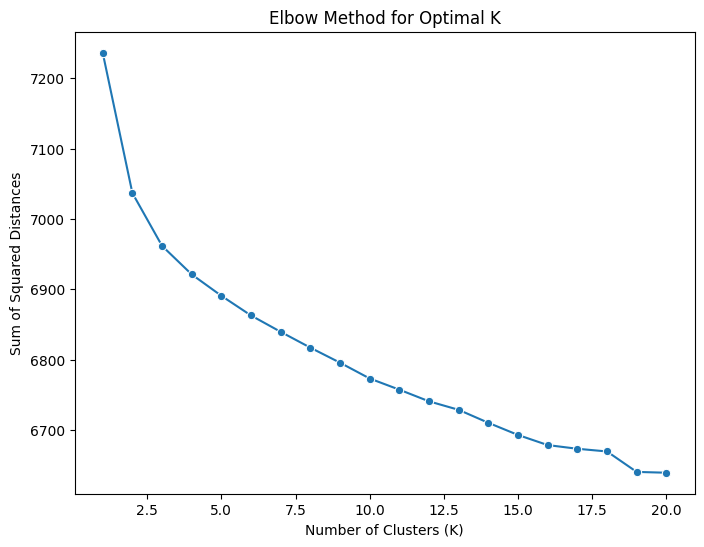

In [ ]:
# Determine the optimal number of clusters using the Elbow Method
sse = []
for k in range(1, 21):
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(tfidf_matrix)
    sse.append(kmeans.inertia_)

# Plotting the Elbow curve
plt.figure(figsize=(8, 6))
sns.lineplot(x=range(1, 21), y=sse, marker='o')
plt.title('Elbow Method for Optimal K')
plt.xlabel('Number of Clusters (K)')
plt.ylabel('Sum of Squared Distances')
plt.show()

In [ ]:
# Apply K-means clustering
num_clusters = 9
kmeans = KMeans(n_clusters=num_clusters, random_state=42)
abdominal_df_final['cluster'] = kmeans.fit_predict(tfidf_matrix)

# Calculate distances from cluster centroids
centroids = kmeans.cluster_centers_
distances = np.linalg.norm(tfidf_matrix - centroids[abdominal_df_final['cluster']], axis=1)

# Set anomaly threshold and flag anomalies
anomaly_threshold = np.percentile(distances, 95)
abdominal_df_final['is_anomaly'] = distances > anomaly_threshold
print("# of Anomalies: ")
print(len(abdominal_df_final[abdominal_df_final['is_anomaly'] == True]))

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


# of Anomalies: 
381


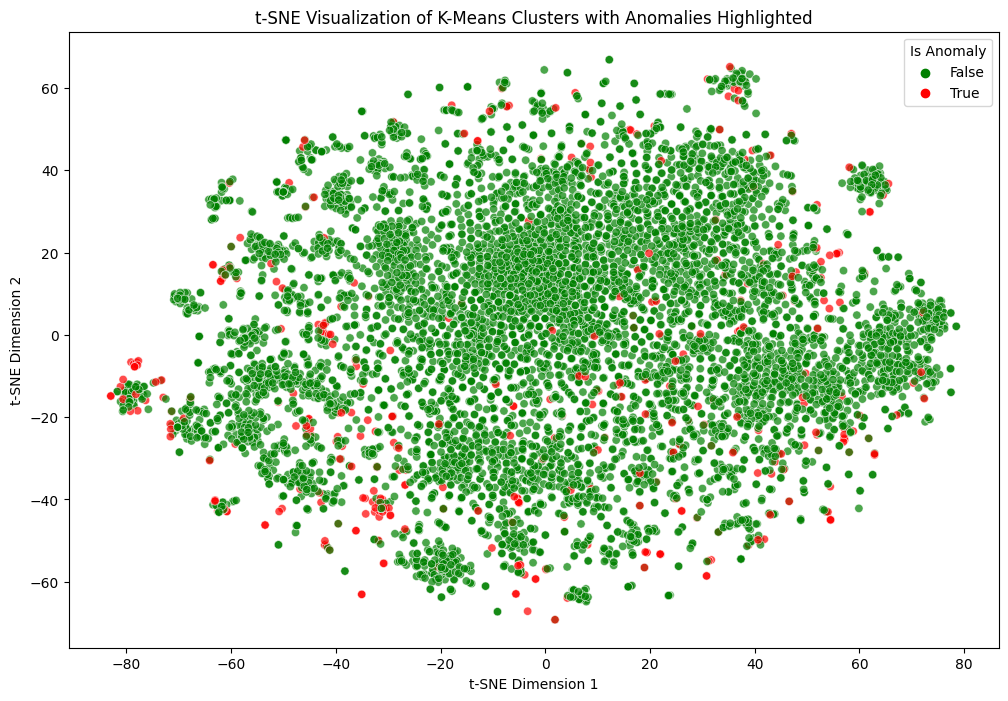

In [ ]:
tsne = TSNE(n_components=2, random_state=42, init='random')
# Convert sparse matrix to dense array
tsne_result = tsne.fit_transform(tfidf_matrix.toarray())

# Add t-SNE results to the DataFrame
abdominal_df_final['tsne1'] = tsne_result[:, 0]
abdominal_df_final['tsne2'] = tsne_result[:, 1]

#Plotting anomalies vs not anomalies
plt.figure(figsize=(12, 8))
sns.scatterplot(x='tsne1', y='tsne2', hue='is_anomaly', data=abdominal_df_final, palette={0: 'green', 1: 'red'}, marker='o', alpha=0.7)
plt.legend(title='Is Anomaly')
plt.title('t-SNE Visualization of K-Means Clusters with Anomalies Highlighted')
plt.xlabel('t-SNE Dimension 1')
plt.ylabel('t-SNE Dimension 2')
plt.show()

In [ ]:
#Subset the data to remove the outliers
abdominal_df_final = abdominal_df_final[abdominal_df_final['is_anomaly'] == False]

# Finishing Text Preprocessing

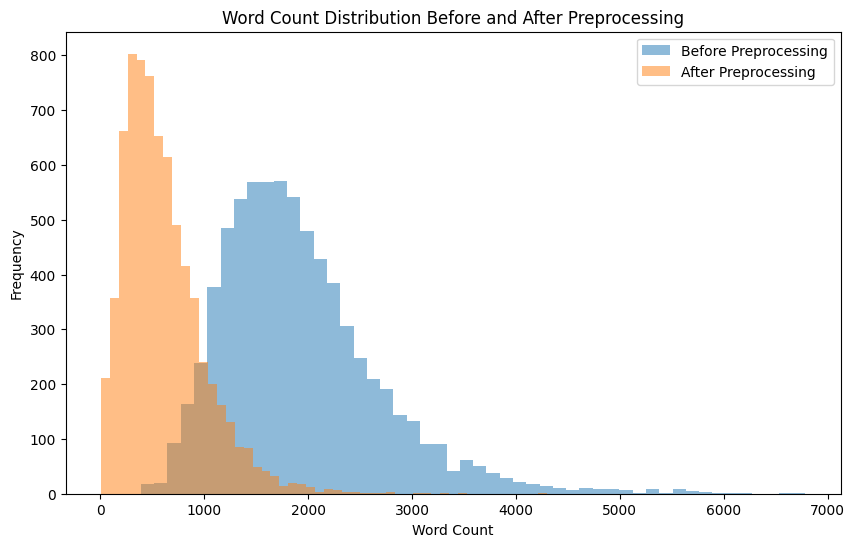

In [ ]:
#Tokenizing into single word units and removing stopwords
abdominal_df_final['text'] = abdominal_df_final['text'].astype(str)
abdominal_df_final['text'] = abdominal_df_final['text'].str.lower().str.split()
stop_words = set(stopwords.words("english"))
abdominal_df_final['text'] = abdominal_df_final['text'].apply(lambda words: [word for word in words if word not in stop_words])

#Stemming using SnowballStemmer
stemmer = SnowballStemmer("english")
abdominal_df_final['text'] = abdominal_df_final['text'].apply(lambda words: [stemmer.stem(word) for word in words])
abdominal_df_final['text'] = abdominal_df_final['text'].apply(lambda words: ' '.join(words))

#Getting rid of underscores, non-alphanumerics, and digits
abdominal_df_final['text'] = abdominal_df_final['text'].apply(lambda text: re.sub('_+', '', text))
abdominal_df_final['text'] = abdominal_df_final['text'].apply(lambda text: re.sub(r'[^a-zA-Z\s]', '', text))
abdominal_df_final['final_text'] = abdominal_df_final['text'].apply(lambda text: re.sub(r'\d+', '', text))

abdominal_df_final['word_count_after'] = abdominal_df_final['final_text'].apply(count_words)

# Plotting
plt.figure(figsize=(10, 6))
plt.hist(abdominal_df_final['word_count_before'], bins=50, alpha=0.5, label='Before Preprocessing')
plt.hist(abdominal_df_final['word_count_after'], bins=50, alpha=0.5, label='After Preprocessing')
plt.title('Word Count Distribution Before and After Preprocessing')
plt.xlabel('Word Count')
plt.ylabel('Frequency')
plt.legend()
plt.show()

In [6]:
#We have now finished data pre-processing. In order to not run the former part of the notebook anymore, I exported the data and called it preprocessed.csv

#abdominal_df_final.to_csv('/content/drive/My Drive/BMIN Final Project/preprocessed.csv')
abdominal_df_final = pd.read_csv('/content/drive/My Drive/BMIN Final Project/preprocessed.csv')

# Apply machine learning techniques

In [7]:
#Mapping the label to numerical values for modelling

label_mapping = {
    'K5900': 0,
    'K921': 1,
    'K922': 2,
    'K5660': 3,
    'K589': 4,
    'K567': 5,
    'K5190': 6,
    'K5090': 7,
    'K861': 8,
}
abdominal_df_final = abdominal_df_final[['final_text', 'icd_code']]
abdominal_df_final['icd_code'] = abdominal_df_final['icd_code'].map(label_mapping)

<ipython-input-7-8c485ff5600d>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  abdominal_df_final['icd_code'] = abdominal_df_final['icd_code'].map(label_mapping)


In [8]:
#Splitting into train/test sets
development_set, validation_set = train_test_split(abdominal_df_final, test_size=0.2, random_state=0)

In [9]:
#Vectorizing the data to get unigrams
tfidf_vectorizer = TfidfVectorizer(ngram_range=(1,1))
#Fit/transform text data to get the TF-IDF features
development_feature_matrix = tfidf_vectorizer.fit_transform(development_set['final_text'])
validation_feature_matrix = tfidf_vectorizer.transform(validation_set['final_text'])

In [10]:
#Getting our training and testing sets from the vectorized data
X_train = development_feature_matrix
y_train = development_set['icd_code']
X_test = validation_feature_matrix
y_test = validation_set['icd_code']

In [11]:
#Plotting function
def plot_confusion_matrix(y_true, y_pred, title='Confusion Matrix'):
    cm = confusion_matrix(y_true, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.title(title)
    plt.show()

Linear SVM Classification Report:
              precision    recall  f1-score   support

           0       0.51      0.61      0.55       208
           1       0.46      0.52      0.49       187
           2       0.47      0.40      0.43       148
           3       0.70      0.65      0.67        79
           4       0.46      0.58      0.52       173
           5       0.57      0.63      0.60       199
           6       0.70      0.54      0.61       108
           7       0.71      0.48      0.57       152
           8       0.73      0.63      0.68       194

    accuracy                           0.56      1448
   macro avg       0.59      0.56      0.57      1448
weighted avg       0.58      0.56      0.56      1448



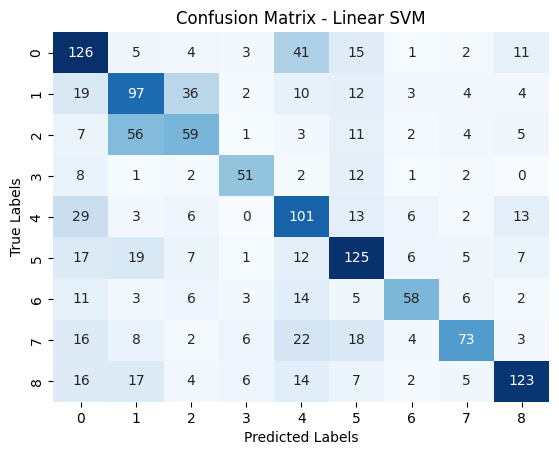

In [ ]:
# Create a linear SVM classifier, training it, and getting predictions
svm_classifier = SVC(kernel='linear')
svm_classifier.fit(X_train, y_train)
predicted_labels_svm = svm_classifier.predict(X_test)

# Calculate precision, recall, and F1-score for the SVM model
report_svm = classification_report(y_test, predicted_labels_svm)
print("Linear SVM Classification Report:")
print(report_svm)
# Generate plots
plot_confusion_matrix(y_test, predicted_labels_svm, title='Confusion Matrix - Linear SVM')

[I 2023-12-07 18:10:12,373] A new study created in memory with name: no-name-33dc40d3-01a8-4bf3-9264-c11d84b550e4
<ipython-input-11-7f3de9ba22bf>:2: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  C = trial.suggest_loguniform('C', 1e-5, 1e5)
[I 2023-12-07 18:18:26,927] Trial 0 finished with value: -0.13328728684873656 and parameters: {'C': 3.7164965425983554e-05, 'kernel': 'poly', 'degree': 4}. Best is trial 0 with value: -0.13328728684873656.
<ipython-input-11-7f3de9ba22bf>:2: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  C = trial.suggest_loguniform('C', 1e-5, 1e5)
[I 2023-12-07 18:27:30,377] Trial 1 finished with value: -0.14243727470378997 and parameters: {'C': 0.2822

Best Hyperparameters: {'C': 4.730082117765609, 'kernel': 'sigmoid'}
Linear SVM Classification Report:
              precision    recall  f1-score   support

           0       0.48      0.55      0.51       208
           1       0.46      0.49      0.47       187
           2       0.39      0.36      0.38       148
           3       0.63      0.62      0.62        79
           4       0.49      0.55      0.52       173
           5       0.58      0.62      0.60       199
           6       0.64      0.55      0.59       108
           7       0.64      0.53      0.58       152
           8       0.72      0.62      0.67       194

    accuracy                           0.54      1448
   macro avg       0.56      0.54      0.55      1448
weighted avg       0.55      0.54      0.55      1448



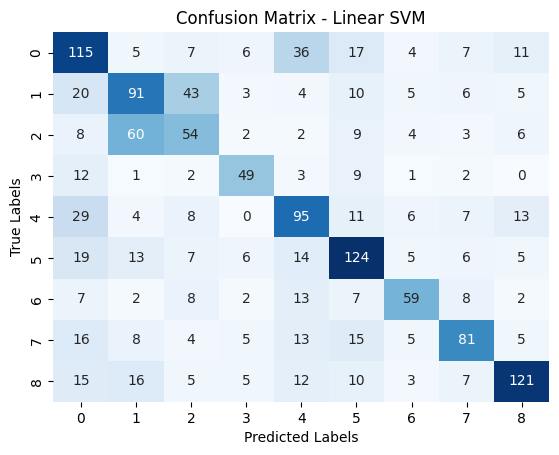

In [ ]:
#Using Optuna to tune the C parameter, different kernels, and different degrees
def objective(trial):
    C = trial.suggest_loguniform('C', 1e-5, 1e5)
    kernel = trial.suggest_categorical('kernel', ['linear', 'poly', 'rbf', 'sigmoid'])
    degree = trial.suggest_int('degree', 2, 5) if kernel == 'poly' else 0

    svm_classifier = SVC(
        C=C,
        kernel=kernel,
        degree = degree
    )
    # Use cross-validation to estimate performance and return negative mean cross-validation score
    scores = cross_val_score(svm_classifier, X_train, y_train, cv=5)
    return -scores.mean()

# Run the optimization and get best hyperparameters
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=10)
best_params = study.best_trial.params
print("Best Hyperparameters:", best_params)

# Create the final SVM classifier with the best hyperparameters, train model, and predicct
tuned_svm_classifier = SVC(**best_params)
tuned_svm_classifier.fit(X_train, y_train)
tuned_svm_pred = tuned_svm_classifier.predict(X_test)

# Calculate precision, recall, and F1-score for the SVM model
report_svm = classification_report(y_test, tuned_svm_pred)
print("Linear SVM Classification Report:")
print(report_svm)
# Generate plots
plot_confusion_matrix(y_test, tuned_svm_pred, title='Confusion Matrix - Linear SVM')

Logistic Regression Classification Report:
              precision    recall  f1-score   support

           0       0.51      0.60      0.55       208
           1       0.48      0.55      0.51       187
           2       0.51      0.38      0.43       148
           3       0.71      0.62      0.66        79
           4       0.50      0.62      0.55       173
           5       0.59      0.70      0.64       199
           6       0.72      0.56      0.63       108
           7       0.76      0.50      0.60       152
           8       0.72      0.66      0.69       194

    accuracy                           0.58      1448
   macro avg       0.61      0.58      0.59      1448
weighted avg       0.60      0.58      0.58      1448



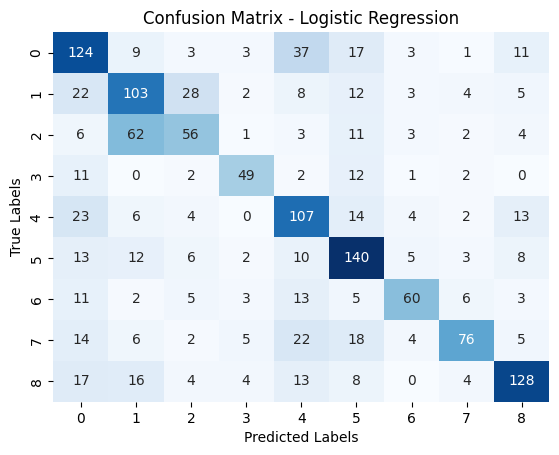

In [ ]:
# Create a Logistic Regression classifier, train, and get predictions
logistic_regression_classifier = LogisticRegression(max_iter=1000)
logistic_regression_classifier.fit(X_train, y_train)
predicted_labels_logistic_regression = logistic_regression_classifier.predict(X_test)

# Calculate precision, recall, and F1-score for the Logistic Regression model
report_logistic_regression = classification_report(y_test, predicted_labels_logistic_regression)
print("Logistic Regression Classification Report:")
print(report_logistic_regression)

# Generate plots
plot_confusion_matrix(y_test, predicted_labels_logistic_regression, title='Confusion Matrix - Logistic Regression')

[I 2023-12-08 01:03:54,820] A new study created in memory with name: no-name-e1f8f7f3-cffe-4638-9760-de0e33abfa0a
<ipython-input-11-09d601c119c3>:2: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  C = trial.suggest_loguniform('C', 1e-5, 1e5)
[I 2023-12-08 01:04:01,982] Trial 0 finished with value: -0.3135296195129802 and parameters: {'C': 0.04566720219701896, 'solver': 'liblinear'}. Best is trial 0 with value: -0.3135296195129802.
<ipython-input-11-09d601c119c3>:2: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  C = trial.suggest_loguniform('C', 1e-5, 1e5)
[I 2023-12-08 01:04:08,748] Trial 1 finished with value: -0.43957270650507185 and parameters: {'C': 0.08343116395316483

Best Hyperparameters for Logistic Regression: {'C': 3.0672994063849726, 'solver': 'lbfgs', 'penalty': 'l2'}


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression Classification Report:
              precision    recall  f1-score   support

           0       0.51      0.57      0.54       208
           1       0.47      0.53      0.50       187
           2       0.47      0.41      0.44       148
           3       0.66      0.61      0.63        79
           4       0.50      0.61      0.55       173
           5       0.62      0.67      0.64       199
           6       0.67      0.56      0.61       108
           7       0.70      0.53      0.61       152
           8       0.75      0.65      0.70       194

    accuracy                           0.58      1448
   macro avg       0.59      0.57      0.58      1448
weighted avg       0.59      0.58      0.58      1448



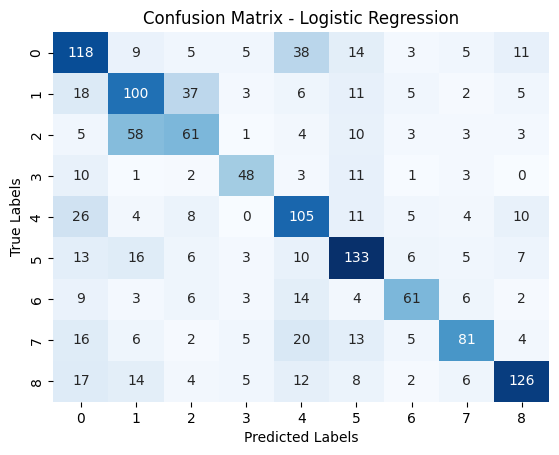

In [ ]:
#Using Optuna to train logistic regression model tuning the C parameter and using different solvers
def objective(trial):
    C = trial.suggest_loguniform('C', 1e-5, 1e5)
    solver = trial.suggest_categorical('solver', ['lbfgs', 'liblinear'])

    # Choose penalty based on the solver
    penalty = 'l1' if solver == 'liblinear' else trial.suggest_categorical('penalty', ['l2'])

    logreg_classifier = LogisticRegression(
        C=C,
        penalty=penalty,
        solver=solver,
        max_iter=1000
    )

    # Use cross-validation to estimate performance and return negative mean cross-validation score
    scores = cross_val_score(logreg_classifier, X_train, y_train, cv=5)
    return -scores.mean()

# Run the optimization and get tuned hyperparameters
study_logreg = optuna.create_study(direction='minimize')
study_logreg.optimize(objective, n_trials=10)
best_params_logreg = study_logreg.best_trial.params
print("Best Hyperparameters for Logistic Regression:", best_params_logreg)

# Create the final Logistic Regression classifier with the best hyperparameters, train, and predict on validation set
tuned_logreg_classifier = LogisticRegression(**best_params_logreg)
tuned_logreg_classifier.fit(X_train, y_train)
tuned_logreg_pred = tuned_logreg_classifier.predict(X_test)

# Calculate precision, recall, and F1-score for the Logistic Regression model
report_logreg = classification_report(y_test, tuned_logreg_pred)
print("Logistic Regression Classification Report:")
print(report_logreg)
# Generate plots
plot_confusion_matrix(y_test, tuned_logreg_pred, title='Confusion Matrix - Logistic Regression')

XGBoost Classification Report:
              precision    recall  f1-score   support

           0       0.59      0.62      0.61       208
           1       0.51      0.52      0.52       187
           2       0.48      0.45      0.46       148
           3       0.69      0.63      0.66        79
           4       0.51      0.62      0.56       173
           5       0.67      0.66      0.66       199
           6       0.76      0.71      0.74       108
           7       0.77      0.63      0.70       152
           8       0.72      0.72      0.72       194

    accuracy                           0.62      1448
   macro avg       0.63      0.62      0.63      1448
weighted avg       0.63      0.62      0.62      1448

Accuracy: 0.6188


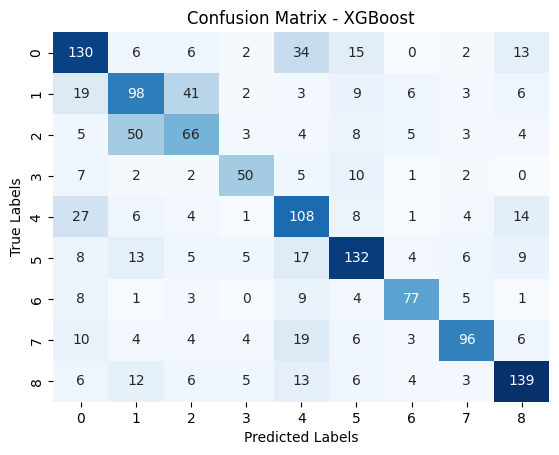

In [ ]:
#Training an XGBoost model and collecting metrics
xgb_classifier = xgb.XGBClassifier()
xgb_classifier.fit(X_train, y_train)
predicted_labels_xgb = xgb_classifier.predict(X_test)

# Calculate precision, recall, and F1-score for the XGBoost model
report_xgb = classification_report(y_test, predicted_labels_xgb)
print("XGBoost Classification Report:")
print(report_xgb)

# Calculate accuracy
accuracy_xgb = accuracy_score(y_test, predicted_labels_xgb)
print(f"Accuracy: {accuracy_xgb:.4f}")

plot_confusion_matrix(y_test, predicted_labels_xgb, title='Confusion Matrix - XGBoost')

[I 2023-12-10 18:09:16,357] A new study created in memory with name: no-name-f51cfaee-43f8-4560-b3d1-6bc6e2639b15
<ipython-input-11-3630d5b4811e>:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda': trial.suggest_loguniform('lambda', 1e-8, 1.0),
<ipython-input-11-3630d5b4811e>:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'alpha': trial.suggest_loguniform('alpha', 1e-8, 1.0),
<ipython-input-11-3630d5b4811e>:9: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'eta': trial.suggest_loguniform('eta', 1e-2, 1e-

Best Hyperparameters for XGBoost: {'lambda': 0.1686184871524561, 'alpha': 2.0166173492745276e-06, 'max_depth': 7, 'eta': 0.04839940253089212, 'subsample': 0.6829416999364105}
XGBoost Classification Report:
              precision    recall  f1-score   support

           0       0.60      0.63      0.62       208
           1       0.47      0.52      0.49       187
           2       0.46      0.39      0.42       148
           3       0.68      0.66      0.67        79
           4       0.46      0.64      0.54       173
           5       0.70      0.63      0.66       199
           6       0.77      0.69      0.73       108
           7       0.82      0.61      0.70       152
           8       0.72      0.73      0.72       194

    accuracy                           0.61      1448
   macro avg       0.63      0.61      0.62      1448
weighted avg       0.62      0.61      0.61      1448



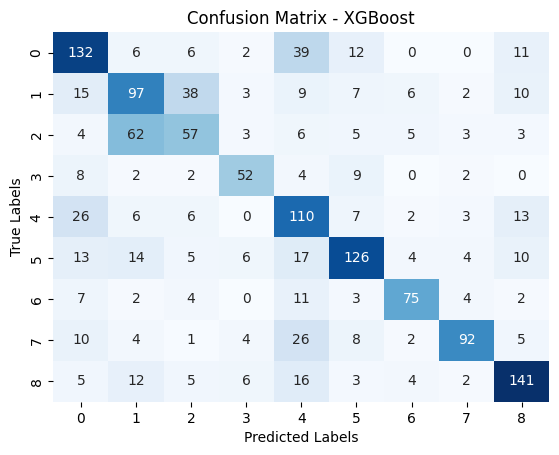

In [11]:
#Using Optuna to tune the XGBoost model
#Tuned lambda, alpha, max_depth, eta, and subsample hyperparameters
def objective_xgb(trial):
    params = {
        'objective': 'binary:logistic',
        'eval_metric': 'logloss',
        'booster': 'gbtree',
        'lambda': trial.suggest_loguniform('lambda', 1e-8, 1.0),
        'alpha': trial.suggest_loguniform('alpha', 1e-8, 1.0),
        'max_depth': trial.suggest_int('max_depth', 3, 9),
        'eta': trial.suggest_loguniform('eta', 1e-2, 1e-1),
        'subsample': trial.suggest_uniform('subsample', 0.1, 1.0),
        'nthread': -1,
        'random_state': 42
    }

    xgb_classifier = xgb.XGBClassifier(**params)

    # Use cross-validation to estimate performance
    scores = cross_val_score(xgb_classifier, X_train, y_train, cv=5, scoring='neg_log_loss')

    # Return the negative mean cross-validation score
    return -scores.mean()

# Run the optimization and get best hyperparameters
study_xgb = optuna.create_study(direction='minimize')
study_xgb.optimize(objective_xgb, n_trials=5)
best_params_xgb = study_xgb.best_trial.params
print("Best Hyperparameters for XGBoost:", best_params_xgb)

# Create the final XGBoost classifier with the best hyperparameters
tuned_xgb_classifier = xgb.XGBClassifier(
    objective='binary:logistic',
    eval_metric='logloss',
    booster='gbtree',
    nthread=-1,
    random_state=42,
    **best_params_xgb
)

# Train the tuned XGBoost model, apply to validation set
tuned_xgb_classifier.fit(X_train, y_train)
tuned_xgb_pred = tuned_xgb_classifier.predict(X_test)

# Calculate precision, recall, and F1-score for the XGBoost model
report_xgb = classification_report(y_test, tuned_xgb_pred)
print("XGBoost Classification Report:")
print(report_xgb)

# Generate plots
plot_confusion_matrix(y_test, tuned_xgb_pred, title='Confusion Matrix - XGBoost')

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


# Splitting the data and encoding labels
train_df, val_df = train_test_split(abdominal_df_final, test_size=0.2, random_state=0)
label_encoder = LabelEncoder()
train_labels = label_encoder.fit_transform(train_df['icd_code'])
val_labels = label_encoder.transform(val_df['icd_code'])

# Tokenizing
vectorizer = CountVectorizer(max_features=10000)
train_texts = vectorizer.fit_transform(train_df['final_text']).toarray()
val_texts = vectorizer.transform(val_df['final_text']).toarray()

# Convert to PyTorch tensors
train_texts = torch.tensor(train_texts, dtype=torch.float32)
train_labels = torch.tensor(train_labels, dtype=torch.long)
val_texts = torch.tensor(val_texts, dtype=torch.float32)
val_labels = torch.tensor(val_labels, dtype=torch.long)

# Defining hyperparameters
# Size of the input features defined here
input_size = train_texts.shape[1]
# Number of output classes defined here
num_classes = len(label_encoder.classes_)
learning_rate = 0.001
epochs = 25
batch_size = 32

# Create DataLoader for training and validation
train_dataset = TensorDataset(train_texts, train_labels)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

val_dataset = TensorDataset(val_texts, val_labels)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

# Defining the CNN model architecture using 1 convolutional layer, batch normalization, dropout, and fully connected layer
class SimpleCNN(nn.Module):
    def __init__(self, input_size, num_classes, dropout_rate=0.5):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv1d(in_channels=1, out_channels=32, kernel_size=3, padding=1)
        self.relu = nn.ReLU()
        self.pool = nn.MaxPool1d(kernel_size=2, stride=2)
        self.batch_norm1 = nn.BatchNorm1d(32)
        self.dropout1 = nn.Dropout(dropout_rate)
        self.fc1 = nn.Linear(32 * (input_size // 2), num_classes)

    #Defining the forward pass through the architecture
    def forward(self, x):
        x = self.conv1(x.unsqueeze(1))
        x = self.relu(x)
        x = self.pool(x)
        x = self.batch_norm1(x)
        x = self.dropout1(x)
        x = x.view(x.size(0), -1)
        x = self.fc1(x)
        return x

# Create model, loss function, and optimizer
model = SimpleCNN(input_size, num_classes)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# Training loop, we will append to these lists
train_losses = []
val_losses = []
precisions = []
recalls = []
accuracies = []

for epoch in range(epochs):
    model.train()
    epoch_train_losses = []
    #Zeroing gradients, getting loss, backward propagating errors, stepping the optimizer
    for inputs, labels in train_loader:
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        #Appending training losses
        epoch_train_losses.append(loss.item())

    #Getting the predictions
    model.eval()
    with torch.no_grad():
        epoch_val_losses = []
        all_predictions = []
        all_labels = []
        for inputs, labels in val_loader:
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            epoch_val_losses.append(loss.item())

            _, predictions = torch.max(outputs, 1)
            all_predictions.extend(predictions.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    # Calculate metrics
    precision = precision_score(all_labels, all_predictions, average='weighted')
    recall = recall_score(all_labels, all_predictions, average='weighted')
    accuracy = accuracy_score(all_labels, all_predictions)

    # Save metrics for plotting
    train_losses.append(np.mean(epoch_train_losses))
    val_losses.append(np.mean(epoch_val_losses))
    precisions.append(precision)
    recalls.append(recall)
    accuracies.append(accuracy)

    print(f"Epoch {epoch + 1}/{epochs}: "
          f"Train Loss: {train_losses[-1]:.4f}, "
          f"Val Loss: {val_losses[-1]:.4f}, "
          f"Precision: {precision:.4f}, "
          f"Recall: {recall:.4f}, "
          f"Accuracy: {accuracy:.4f}")


Epoch 1/25: Train Loss: 6.3253, Val Loss: 5.4801, Precision: 0.5071, Recall: 0.4448, Accuracy: 0.4448
Epoch 2/25: Train Loss: 2.4676, Val Loss: 5.1662, Precision: 0.4835, Recall: 0.4579, Accuracy: 0.4579
Epoch 3/25: Train Loss: 1.7083, Val Loss: 4.6695, Precision: 0.4833, Recall: 0.4765, Accuracy: 0.4765
Epoch 4/25: Train Loss: 1.3435, Val Loss: 4.7594, Precision: 0.4888, Recall: 0.4744, Accuracy: 0.4744
Epoch 5/25: Train Loss: 1.0357, Val Loss: 4.8317, Precision: 0.4768, Recall: 0.4689, Accuracy: 0.4689
Epoch 6/25: Train Loss: 0.9730, Val Loss: 4.5602, Precision: 0.4783, Recall: 0.4765, Accuracy: 0.4765
Epoch 7/25: Train Loss: 0.7755, Val Loss: 4.3632, Precision: 0.4817, Recall: 0.4662, Accuracy: 0.4662
Epoch 8/25: Train Loss: 0.7282, Val Loss: 4.3024, Precision: 0.4935, Recall: 0.4696, Accuracy: 0.4696
Epoch 9/25: Train Loss: 0.6415, Val Loss: 4.1059, Precision: 0.4979, Recall: 0.4731, Accuracy: 0.4731
Epoch 10/25: Train Loss: 0.5387, Val Loss: 3.6964, Precision: 0.5048, Recall: 0.50

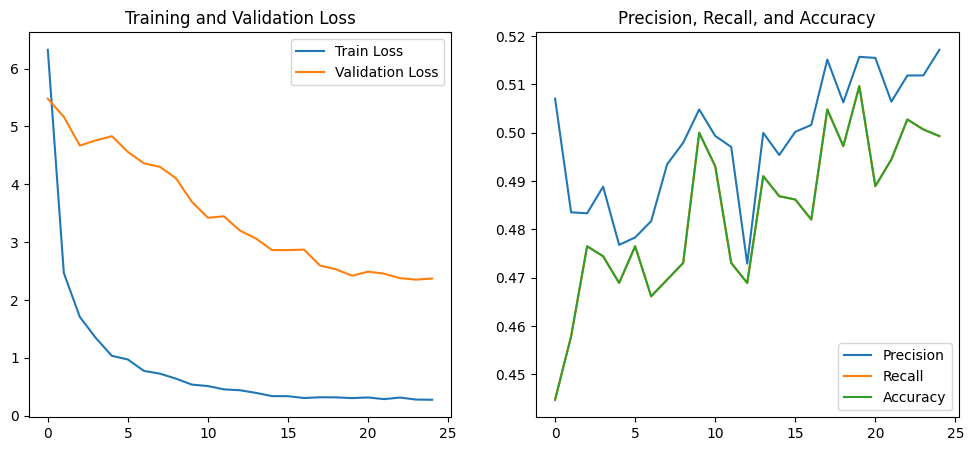

In [ ]:
# Plotting learning curve
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.legend()
plt.title('Training and Validation Loss')

plt.subplot(1, 2, 2)
plt.plot(precisions, label='Precision')
plt.plot(recalls, label='Recall')
plt.plot(accuracies, label='Accuracy')
plt.legend()
plt.title('Precision, Recall, and Accuracy')

plt.show()

In [15]:
# Splitting the data and encoding labels
train_df, val_df = train_test_split(abdominal_df_final, test_size=0.2, random_state=0)
label_encoder = LabelEncoder()
train_labels = label_encoder.fit_transform(train_df['icd_code'])
val_labels = label_encoder.transform(val_df['icd_code'])

# Tokenizing
vectorizer = CountVectorizer(max_features=10000)
train_texts = vectorizer.fit_transform(train_df['final_text']).toarray()
val_texts = vectorizer.transform(val_df['final_text']).toarray()

# Convert to PyTorch tensors
train_texts = torch.tensor(train_texts, dtype=torch.float32)
train_labels = torch.tensor(train_labels, dtype=torch.long)
val_texts = torch.tensor(val_texts, dtype=torch.float32)
val_labels = torch.tensor(val_labels, dtype=torch.long)

# Defining our hyperparameters. We train for more epochs this time
input_size = train_texts.shape[1]  # Size of the input features
num_classes = len(label_encoder.classes_)  # Number of output classes
learning_rate = 0.001
epochs = 75
batch_size = 32

# Create DataLoader for training and validation
train_dataset = TensorDataset(train_texts, train_labels)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_dataset = TensorDataset(val_texts, val_labels)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

# Define the CNN architecture using 2 convolutional layers, 1 maxpooling layer, 1 batch normalization layer, 1 dropout layer, and 1 fully connected layer
class SimpleCNN(nn.Module):
    def __init__(self, input_size, num_classes, dropout_rate=0.5):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv1d(in_channels=1, out_channels=32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv1d(in_channels=32, out_channels=64, kernel_size=3, padding=1)
        self.relu = nn.ReLU()
        self.pool = nn.MaxPool1d(kernel_size=2, stride=2)
        self.batch_norm1 = nn.BatchNorm1d(64)
        self.dropout1 = nn.Dropout(dropout_rate)
        self.fc_input_size = 64 * (input_size // 4)  # Adjusted based on the pooling operation
        self.fc1 = nn.Linear(self.fc_input_size, num_classes)

    #Defining the forward pass using this architecture
    def forward(self, x):
        x = self.conv1(x.unsqueeze(1))
        x = self.relu(x)
        x = self.pool(x)
        x = self.conv2(x)
        x = self.relu(x)
        x = self.pool(x)
        x = self.batch_norm1(x)
        x = self.dropout1(x)
        x = x.view(x.size(0), -1)
        x = self.fc1(x)
        return x

# Create model, loss function, and optimizer
model = SimpleCNN(input_size, num_classes)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# Training loop
train_losses = []
val_losses = []
precisions = []
recalls = []
accuracies = []

#Zeroing gradient, calculating loss, backpropagating errors, stepping the optimizer
for epoch in range(epochs):
    model.train()
    epoch_train_losses = []
    for inputs, labels in train_loader:
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        epoch_train_losses.append(loss.item())

#Getting predictions
    model.eval()
    with torch.no_grad():
        epoch_val_losses = []
        all_predictions = []
        all_labels = []
        for inputs, labels in val_loader:
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            epoch_val_losses.append(loss.item())

            _, predictions = torch.max(outputs, 1)
            all_predictions.extend(predictions.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    # Calculate metrics
    precision = precision_score(all_labels, all_predictions, average='weighted')
    recall = recall_score(all_labels, all_predictions, average='weighted')
    accuracy = accuracy_score(all_labels, all_predictions)

    # Save metrics for plotting
    train_losses.append(np.mean(epoch_train_losses))
    val_losses.append(np.mean(epoch_val_losses))
    precisions.append(precision)
    recalls.append(recall)
    accuracies.append(accuracy)

    print(f"Epoch {epoch + 1}/{epochs}: "
          f"Train Loss: {train_losses[-1]:.4f}, "
          f"Val Loss: {val_losses[-1]:.4f}, "
          f"Precision: {precision:.4f}, "
          f"Recall: {recall:.4f}, "
          f"Accuracy: {accuracy:.4f}")


Epoch 1/75: Train Loss: 2.8318, Val Loss: 1.6560, Precision: 0.5528, Recall: 0.4986, Accuracy: 0.4986
Epoch 2/75: Train Loss: 1.2364, Val Loss: 1.8055, Precision: 0.5403, Recall: 0.4924, Accuracy: 0.4924
Epoch 3/75: Train Loss: 0.9178, Val Loss: 2.0715, Precision: 0.5372, Recall: 0.4351, Accuracy: 0.4351
Epoch 4/75: Train Loss: 0.8002, Val Loss: 1.7755, Precision: 0.5529, Recall: 0.5421, Accuracy: 0.5421
Epoch 5/75: Train Loss: 0.6929, Val Loss: 1.8834, Precision: 0.5415, Recall: 0.5152, Accuracy: 0.5152
Epoch 6/75: Train Loss: 0.6532, Val Loss: 2.0510, Precision: 0.5315, Recall: 0.4993, Accuracy: 0.4993
Epoch 7/75: Train Loss: 0.5817, Val Loss: 1.8960, Precision: 0.5637, Recall: 0.5283, Accuracy: 0.5283
Epoch 8/75: Train Loss: 0.5456, Val Loss: 1.9265, Precision: 0.5395, Recall: 0.5318, Accuracy: 0.5318
Epoch 9/75: Train Loss: 0.5026, Val Loss: 2.0006, Precision: 0.5316, Recall: 0.5214, Accuracy: 0.5214
Epoch 10/75: Train Loss: 0.4609, Val Loss: 2.0056, Precision: 0.5284, Recall: 0.52

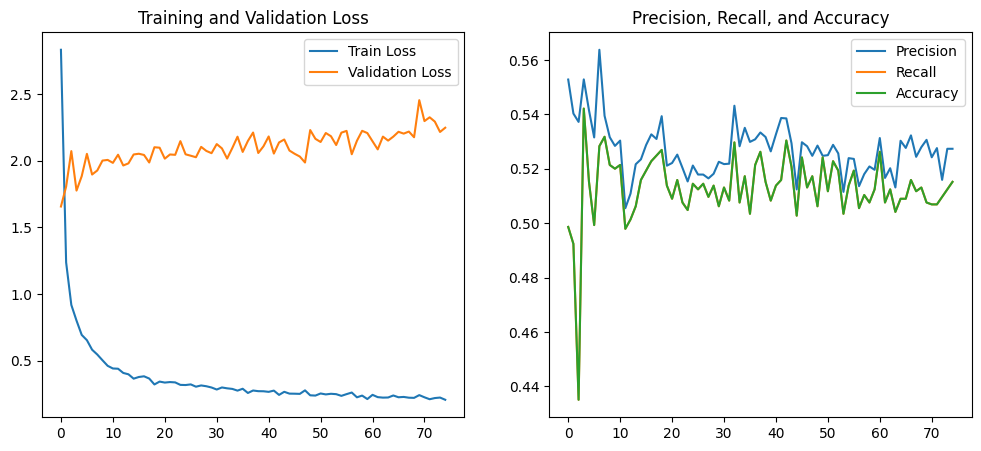

In [16]:
# Plotting learning curve
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.legend()
plt.title('Training and Validation Loss')

plt.subplot(1, 2, 2)
plt.plot(precisions, label='Precision')
plt.plot(recalls, label='Recall')
plt.plot(accuracies, label='Accuracy')
plt.legend()
plt.title('Precision, Recall, and Accuracy')

plt.show()

# Grouping ICD-10 Codes

In [ ]:
#This section was experimental, I didn't include it in the report. I tried grouping different ICD-10 codes together based on similar ailments manually and feed them into machine learning models
#It seemed to slightly improve accuracy and may be great for future work!

In [ ]:
code_groups = {
    "Constipation": ["K5900", "K5909", "K5903", "K5901", "K5904"],
    "Pancreatitis": ["K861", "K859"],
    "Crohn's Disease": ["K5090", "K5010", "K50912", "K50911", "K50919"],
    "Ulcerative Colitis": ["K5190", "K5100", "K5150"],
    "Irritable Bowel Syndrome": ["K580", "K589"],
    "Intestinal Obstruction": ["K5660", "K5669"],
    "Gastrointestinal Hemorrhage": ["K922", "K929"],
    "Functional Disorders": ["K30", "K591", "K595"],
    "Other": ["R100", "R102", "K904", "R101", "R103", "R104", "K921", "K9581", "K9589", "K953", "K954", "K567", "K57", "K56", "K58", "K59", "K60", "K61", "K62", "K63", "K64", "K65", "K66", "K67", "K68", "K69", "K70", "K71", "K73", "K74", "K75"]
}

# Create a new column 'condition_group' based on the mapping
df['condition_group'] = df['icd_code'].map(lambda x: next((group for group, codes in code_groups.items() if x in codes), None))

# Display the counts for each condition group
condition_group_counts = df['condition_group'].value_counts()
print(condition_group_counts)

abdominal_codes_final = ['Constipation', 'Irritable Bowel Syndrome', 'Pancreatitis', 'Crohn\'s Disease', 'Gastrointestinal Hemorrhage', 'Ulcerative Colitis', 'Intestinal Obstruction']
abdominal_df = df[df['condition_group'].isin(abdominal_codes_final)]

Constipation                   9170
Other                          3323
Irritable Bowel Syndrome       1316
Pancreatitis                   1284
Crohn's Disease                1055
Gastrointestinal Hemorrhage     875
Ulcerative Colitis              776
Intestinal Obstruction          606
Functional Disorders            249
Name: condition_group, dtype: int64


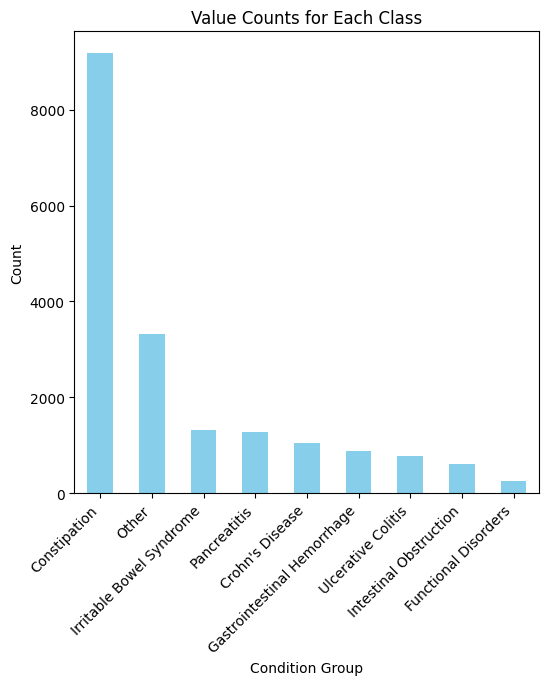

In [ ]:
# Display the counts for each condition group
#We note that there is a significant class imbalance so we sample from each one
import matplotlib.pyplot as plt

condition_group_counts = df['condition_group'].value_counts()
plt.figure(figsize=(6, 6))
condition_group_counts.plot(kind='bar', color='skyblue')
plt.title('Value Counts for Each Class')
plt.xlabel('Condition Group')
plt.ylabel('Count')
plt.xticks(rotation=45, ha='right')
plt.show()


In [ ]:
# Define the target number of samples per class
target_samples_per_class = 1050
sampled_df = pd.DataFrame()

# Iterate over each class
for icd_code, group in abdominal_df.groupby('condition_group'):
    # Calculate the number of samples to take for this class and take a random sample
    samples_to_take = min(target_samples_per_class, len(group))
    sampled_df = pd.concat([sampled_df, group.sample(samples_to_take, random_state=42)])


print(sampled_df['condition_group'].value_counts())

abdominal_df_final = sampled_df.copy()

Constipation                   1050
Crohn's Disease                1050
Irritable Bowel Syndrome       1050
Pancreatitis                   1050
Gastrointestinal Hemorrhage     875
Ulcerative Colitis              776
Intestinal Obstruction          606
Name: condition_group, dtype: int64


In [ ]:
label_mapping = {
    'Constipation': 0,
    'Crohn\'s Disease': 1,
    'Irritable Bowel Syndrome': 2,
    'Pancreatitis': 3,
    'Gastrointestinal Hemorrhage': 4,
    'Ulcerative Colitis': 5,
    'Intestinal Obstruction': 6
}
abdominal_df_final['condition_group'] = abdominal_df_final['condition_group'].map(label_mapping)

In [ ]:
# Apply the function to the 'text' column
abdominal_df_final['HPI'] = abdominal_df_final['text'].apply(extract_history_of_present_illness)
abdominal_df_final['Chief_Complaint'] = abdominal_df_final['text'].apply(extract_chief_complaint)
abdominal_df_final['acute_issues'] = abdominal_df_final['text'].apply(extract_acute_problems)
abdominal_df_final['HPI'] = abdominal_df_final['HPI'].fillna('')
abdominal_df_final['Chief_Complaint'] = abdominal_df_final['Chief_Complaint'].fillna('')
abdominal_df_final['final_text'] = abdominal_df_final['Chief_Complaint'] + abdominal_df_final['acute_issues']
abdominal_df_final = abdominal_df_final[['final_text', 'condition_group']]

In [ ]:
#Tokenizing into single word units and removing stopwords
abdominal_df_final['final_text'] = abdominal_df_final['final_text'].astype(str)
abdominal_df_final['final_text'] = abdominal_df_final['final_text'].str.lower().str.split()
stop_words = set(stopwords.words("english"))
abdominal_df_final['final_text'] = abdominal_df_final['final_text'].apply(lambda words: [word for word in words if word not in stop_words])

#Stemming
stemmer = SnowballStemmer("english")
abdominal_df_final['final_text'] = abdominal_df_final['final_text'].apply(lambda words: [stemmer.stem(word) for word in words])
abdominal_df_final['final_text'] = abdominal_df_final['final_text'].apply(lambda words: ' '.join(words))

abdominal_df_final['final_text'] = abdominal_df_final['final_text'].apply(lambda text: re.sub('_+', '', text))
abdominal_df_final['final_text'] = abdominal_df_final['final_text'].apply(lambda text: re.sub(r'[^a-zA-Z\s]', '', text))
abdominal_df_final['final_text'] = abdominal_df_final['final_text'].apply(lambda text: re.sub(r'\d+', '', text))


development_set, validation_set = train_test_split(abdominal_df_final, test_size=0.2, random_state=0)

#This includes unigrams and bigrams
tfidf_vectorizer = TfidfVectorizer(ngram_range=(1,1))
#Fit/transform text data to get the TF-IDF features
tfidf_train = tfidf_vectorizer.fit_transform(development_set['final_text'])
tfidf_val = tfidf_vectorizer.transform(validation_set['final_text'])




<ipython-input-27-437edb82a5c2>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  abdominal_df_final['final_text'] = abdominal_df_final['final_text'].astype(str)
<ipython-input-27-437edb82a5c2>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  abdominal_df_final['final_text'] = abdominal_df_final['final_text'].str.lower().str.split()
<ipython-input-27-437edb82a5c2>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value ins

Linear SVM Classification Report:
                             precision    recall  f1-score   support

               Constipation       0.52      0.65      0.58       210
            Crohn's Disease       0.73      0.57      0.64       205
Gastrointestinal Hemorrhage       0.71      0.73      0.72       179
     Intestinal Obstruction       0.73      0.69      0.71       119
   Irritable Bowel Syndrome       0.47      0.53      0.50       212
               Pancreatitis       0.78      0.78      0.78       209
         Ulcerative Colitis       0.74      0.57      0.64       158

                   accuracy                           0.64      1292
                  macro avg       0.67      0.65      0.65      1292
               weighted avg       0.66      0.64      0.65      1292



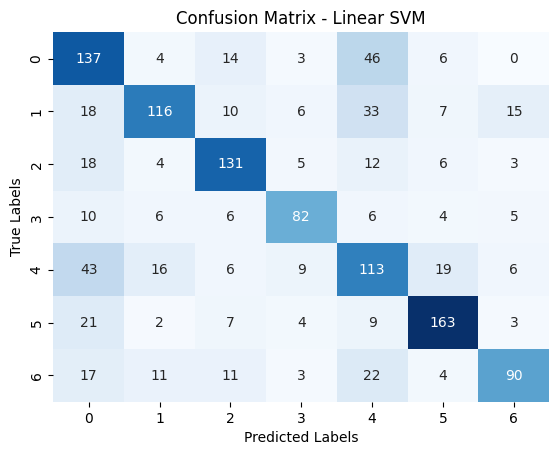

In [ ]:
from sklearn.svm import SVC
from sklearn.metrics import classification_report


X_train = development_feature_matrix
y_train = development_set['condition_group']
X_validation = validation_feature_matrix
y_validation = validation_set['condition_group']


svm_classifier = SVC(kernel='linear')

# Train the classifier using the development set and apply to validation set
svm_classifier.fit(X_train, y_train)
predicted_labels_svm = svm_classifier.predict(X_validation)

# Calculate precision, recall, and F1-score for the SVM model
report_svm = classification_report(y_validation, predicted_labels_svm)
print("Linear SVM Classification Report:")
print(report_svm)
# Generate plots
plot_confusion_matrix(y_validation, predicted_labels_svm, title='Confusion Matrix - Linear SVM')

Accuracy: 0.641640866873065
Classification Report:
                              precision    recall  f1-score   support

               Constipation       0.54      0.65      0.59       210
            Crohn's Disease       0.72      0.60      0.65       205
Gastrointestinal Hemorrhage       0.68      0.76      0.72       179
     Intestinal Obstruction       0.74      0.64      0.68       119
   Irritable Bowel Syndrome       0.51      0.48      0.50       212
               Pancreatitis       0.70      0.79      0.74       209
         Ulcerative Colitis       0.71      0.58      0.63       158

                   accuracy                           0.64      1292
                  macro avg       0.66      0.64      0.64      1292
               weighted avg       0.65      0.64      0.64      1292



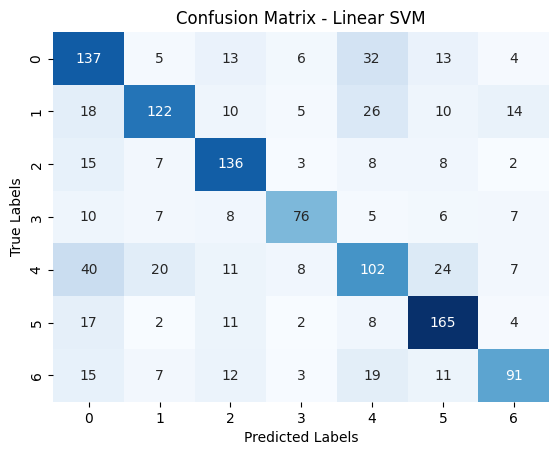

In [ ]:
# Initialize the Random Forest Classifier model
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)

# Train the model on the training set
rf_model.fit(X_train, y_train)

# Make predictions on the test set
y_pred = rf_model.predict(X_validation)

# Evaluate the model
accuracy = accuracy_score(y_validation, y_pred)
print(f"Accuracy: {accuracy}")

# Additional metrics
classification_rep = classification_report(y_validation, y_pred)
print("Classification Report:\n", classification_rep)

# Confusion Matrix
cm = confusion_matrix(y_validation, y_pred)

# Plot Confusion Matrix
plot_confusion_matrix(y_validation, y_pred, title='Confusion Matrix - Linear SVM')